**Reconnaissance de caractères mathématiques**

On commence par importer ce dont on aura besoin

In [ ]:
import cv2
import argparse
import random
import numpy as np
import time
from google.colab.patches import cv2_imshow

On importe l'image sur laquelle on travaille

In [ ]:
#("Projetinfo_1.jpg"
image = cv2.imread("formule.jpg")
image = np.float32(image)
#image = cv2.resize(image, (244,244))

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()   # 
ss.setBaseImage(image)

#Un des deux :
ss.switchToSelectiveSearchFast()
#ss.switchToSelectiveSearchQuality()


In [ ]:
start = time.time()
rects = ss.process()
end = time.time()
print(len(rects))
print(f"Duration : {int(100*(end-start))/100}s")

447
Duration : 12.49s


In [ ]:
rects = rects[(rects[:,1]>0) & (rects[:,0]>0) & (rects[:, 2]>0) & (rects[:, 3]>0)]

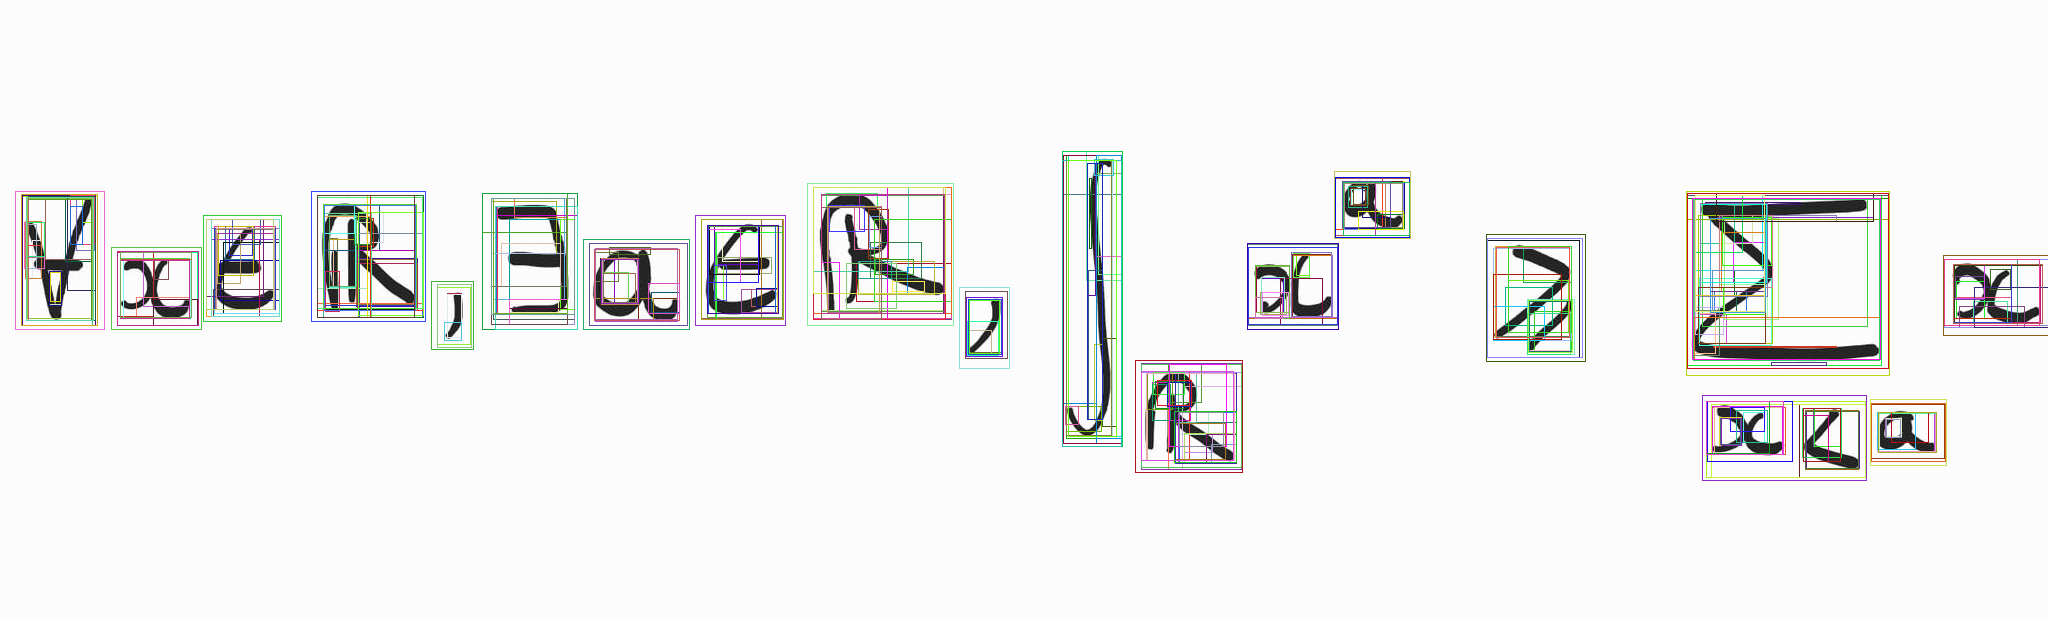

In [ ]:
output=image.copy()
for i in range(len(rects)):
  (x,y,w,h) = rects[i]
  color = [random.randint(0,255) for j in range(0,3)]
  cv2.rectangle(output, (x,y), (x+w, y+h), color, 1)
  #cv2_imshow(output)
  #print(i)
cv2_imshow(output)

In [ ]:
areas = [image[y:y+h, x:x+w] for (x,y,w,h) in rects]

In [ ]:
def scaling(imgs):
  out = imgs.copy()
  for i in range(len(out)):
    try:
      out[i] = cv2.cvtColor(out[i], cv2.COLOR_BGR2GRAY)
    except:
      pass
    h,w = out[i].shape
    #print(h,w,i)
    if h > w:
      if w*32//h > 0:
        out[i] = cv2.resize(out[i], (w*32//h , 32))
      else:
        out[i] = np.zeros((32,32))
    else:
      if h*32//w > 0:
        out[i] = cv2.resize(out[i], (32 , h*32//w))
      else:
        out[i] = np.zeros((32,32))
  return out


In [ ]:
def padding(imgs):
  out = []
  for i in range(len(imgs)):
    out.append(np.zeros((32,32)))

    h,w = imgs[i].shape
    if h < w:
      if h%2 == 0:
        out[i][(32-h)//2 : 32-(32-h)//2,:] = imgs[i]
      else:
        out[i][(32-(h+1))//2 : 32-(32-h+1)//2,:] = imgs[i]
    else:
      if w%2 == 0:
        #print(imgs[i].shape, out[i][:, (32-w)//2 : 32-(32-w)//2].shape, w,h)
        out[i][:, (32-w)//2 : 32-(32-w)//2] = imgs[i]
      else:
        out[i][:, (32-(w+1))//2 : 32-(32-w+1)//2] = imgs[i]
    #cv2_imshow(out[i])
  return np.array(out)


In [ ]:
def crop(img, th=25):
  h,w = img.shape
  h1 = 0
  while (img[h1,:] <= th*np.ones(w)).all():
      h1 += 1
  h1 += -1
  if h1 < 0:
    h1 = 0
  h2 = h-1
  while (img[h2,:] <= th*np.ones(w)).all():
      h2 -= 1
  h2 += 1
  if h2 > h-1:
    h1 = h-1
  w1 = 0
  while (img[:,w1] <= th*np.ones(h)).all():
      w1 += 1
  w1 += -1
  if w1 < 0:
    w1 = 0 
  w2 = w-1
  while (img[:,w2] <= th*np.ones(h)).all():
      w2 -= 1
  w2 += 1
  if w2 > w-1:
    w2 = w-1
  #print(h1,h2,w1,w2)
  return img[h1:(h2+1), w1:(w2+1)]

On crée le modèle de classification avec un MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data.npy to data.npy
Saving labels.npy to labels.npy


In [ ]:
chars = np.load('data/data.npy')
labels = np.load('labels/labels.npy')
chars = [crop(im) for im in chars]
chars = scaling(chars)

chars = padding(chars)

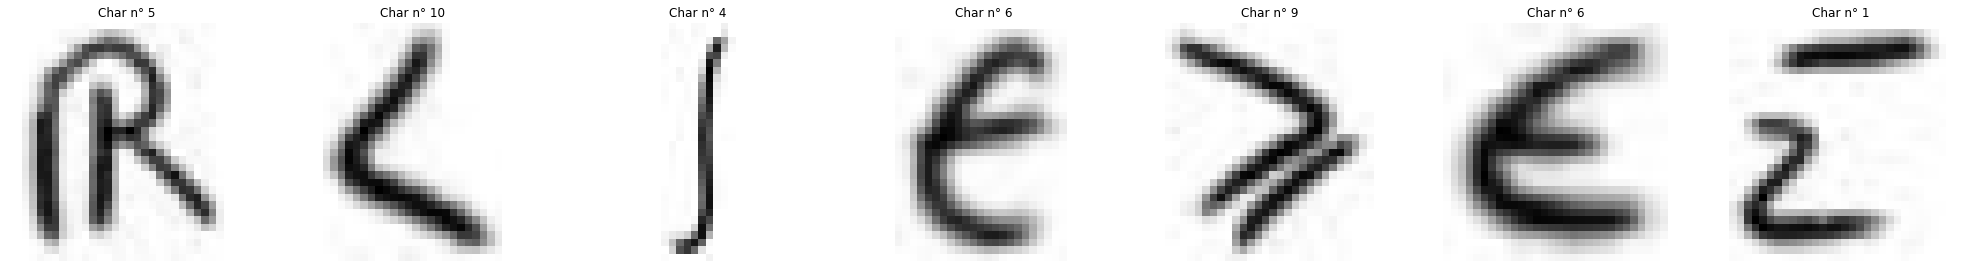

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=7, figsize=(35, 10))
for ax, image, label in zip(axes, chars, labels):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(f'Char n° {label}')

In [ ]:
characters = ["a",
              "\sum ",
              "\\forall ",
              "\exists ",
              "\int",
              "\mathbb{R}",
              "\in ",
              ",",
              "x",
              "\geq ",
              "<",
              "\leq ",
              "=",
              "i",
              "0",
              "1"]

In [ ]:
n_samples = len(chars)
data = chars.reshape((n_samples, -1))



X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=False)

clf = MLPClassifier(random_state=1, max_iter=100)

clf.fit(X_train, y_train)

predicted = clf.predict(X_test)


In [ ]:
print(f"Classification report for classifier {clf}:\n"
      f"{metrics.classification_report(y_test, predicted)}\n")

Classification report for classifier MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=100,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False):
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        27
           1       1.00      1.00      1.00        39
           2       1.00      1.00      1.00        37
           3       1.00      0.96      0.98        26
           4       1.00      1.00      1.00        29
           5       1.00      0.96      0.98        27
           6       0.97      1.00      0.98        29
      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


On l'applique à nos images précedentes :

In [ ]:
#print(areas[1][12][:60])
#print(treatment([areas[1]]))
#plt.imshow(padding(scaling(treatment([areas[1]])))[0])
#print(scaled[1])
#print(out[1][15])

In [ ]:
def treatment(imgs):
  out = []
  for i in range(len(imgs)):
    try:
      out.append(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2GRAY))
    except:
      out.append(imgs[i].copy())
    #print(out[i].shape)
    for j in range(len(out[i])):
      for k in range(len(out[i][j])):
        if out[i][j][k]>240:
          out[i][j][k] == 255
        out[i][j][k] = 255 - out[i][j][k]
  return out

In [ ]:
out = padding(scaling(treatment(areas)))

predicted = clf.predict_proba(out.reshape((len(out), -1)))
prediction=[]
for i in range(len(predicted)):
  max=predicted[i][0]
  max_j = 0
  for j in range(len(predicted[i])):
    if predicted[i][j] > max:
      max = predicted[i][j]
      max_j = j
  prediction.append([max_j, max])
prediction = np.array(prediction)

In [ ]:
#Méthode NMS :

import numpy as np

#LCAR : liste avec là où je dois avoir tous les carrés
#PREDIC : ensemble de tous les couples avec [.,.] avec en deuxième position la proba (=score du carré)
#CARFIN : ensemble des tous les carrés qu'on garde
#S : Seuil de supperpostion maximum entre 2 carrés  

def NMS(LCAR,PREDIC,S): #Première version, marche moins bien
    CARFIN = []
    PROBFIN = []
    PREDICFIN = []
    while LCAR.size >0:
        #On cherche le carré avec le score le plus élevé 
        Caparam=None
        pmax=0
        indmax=0
        for i in range(len(PREDIC)):    #recherche du carré au score le plus élevé 
            if PREDIC[i][1]>pmax:
                pmax=PREDIC[i][1]
                indmax= i
        Caparam= LCAR[indmax]

        PROBFIN.append(pmax)
        CARFIN.append(Caparam)
        PREDICFIN.append(PREDIC[indmax])
        LCAR = np.delete(LCAR, indmax, 0)
        PREDIC = np.delete(PREDIC,indmax, 0)

        #print(LCAR.shape)
        #print(LCAR.size)
        #print(PREDIC.shape)
        
        for i in range(len(LCAR)-1,-1, -1):
            box = LCAR[i]
            #print(Caparam, box)
            x1,y1,w1,h1 = Caparam
            x2,y2,w2,h2 = box
            inter = intersection(x1,y1,w1,h1,x2,y2,w2,h2)
            un = union(x1,y1,w1,h1,x2,y2,w2,h2)
            IoU = inter/un
            #seuil de précision à déterminer 
            #print(IoU)
            if IoU > S :
                LCAR = np.delete(LCAR,i, 0)
                PREDIC = np.delete(PREDIC,i, 0)
    
    return CARFIN , PROBFIN, PREDICFIN

In [ ]:
def intersection(x1,y1,w1,h1,x2,y2,w2,h2):
  sum = 0
  for i in range(x1, x1+w1):
    for j in range(y1, y1+h1):
      if i >= x2 and i < x2+w2 and j >= y2 and j < y2+h2:
        sum += 1
  return sum

def union(x1,y1,w1,h1,x2,y2,w2,h2):
  return w1*h1 + w2*h2 - intersection(x1,y1,w1,h1,x2,y2,w2,h2)

In [ ]:
nms = NMS(rects, prediction, 0.1)

NameError: ignored

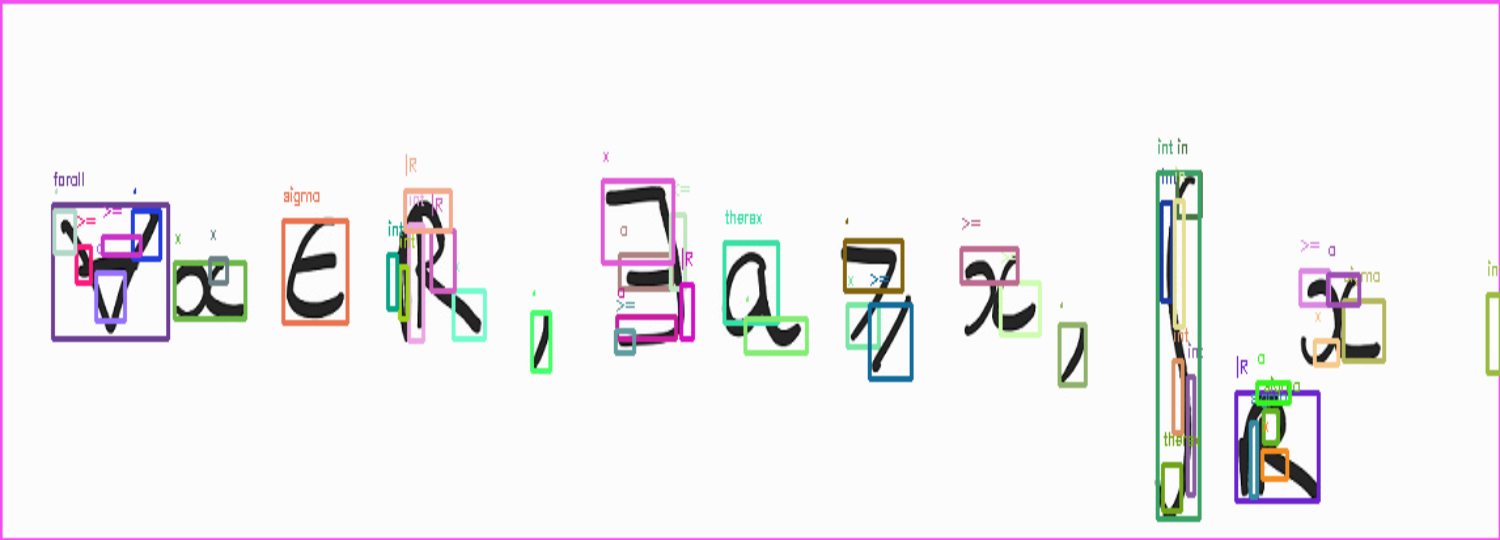

In [ ]:
image = cv2.imread("formule.jpg")
output=image.copy()
cf, pbf, pdf = nms
for i in range(len(cf)):
  (x,y,w,h) = cf[i]
  color = [random.randint(0,255) for j in range(0,3)]
  cv2.rectangle(output, (x,y), (x+w, y+h), color, 2)
  cv2.putText(output, characters[int(pdf[i][0])], (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, color, 1)
  #cv2_imshow(output)
  #print(i)
output_big = cv2.resize(output, (1500, 540))
cv2_imshow(output_big)

#print(pdf)

In [ ]:
def new_nms(boxes, thr):
  if len(boxes) == 0:
    return []
  if boxes.dtype.kind == "i":
    boxes = boxes.astype("float")
  pick = []
  x1 = boxes[:,0]
  y1 = boxes[:,1]
  x2 = boxes[:,2] + boxes[:,0]
  y2 = boxes[:,3] + boxes[:,1]
  
  area = (x2 - x1 + 1) * (y2 - y1 + 1)
  idxs = np.argsort(y2)
  while len(idxs) > 0:
    last = len(idxs) -1
    i = idxs[last]
    pick.append(i)
    #IoU determination
    xx1 = np.maximum(x1[i], x1[idxs[:last]])
    yy1 = np.maximum(y1[i], y1[idxs[:last]])
    xx2 = np.minimum(x2[i], x2[idxs[:last]])
    yy2 = np.minimum(y2[i], y2[idxs[:last]])
  
    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)

    overlap = (w * h) / area[idxs[:last]]
    #print(overlap)

    idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > thr)[0])))
  print(boxes.shape)
  print(boxes[pick].astype("int"))
  return pick


In [ ]:
pick = new_nms(rects, 0.5)

(446, 4)
[[1702  395  164   85]
 [1135  360  107  112]
 [1870  399   76   66]
 [1062  194   59  252]
 [1686  191  203  184]
 [ 959  287   50   81]
 [1486  234   99  127]
 [ 431  281   42   68]
 [1943  255  105   80]
 [ 583  239  106   90]
 [1247  243   91   86]
 [  15  191   89  138]
 [ 111  247   90   82]
 [ 495  206   82  123]
 [ 807  183  146  142]
 [ 695  215   90  110]
 [ 203  215   78  106]
 [ 311  191  114  130]
 [1334  171   76   67]
 [1094  159   19   16]]


In [ ]:
boxes = rects.astype("float")[pick].astype("int")
preds = prediction[pick]
preds

array([[14.        ,  0.73912057],
       [ 5.        ,  1.        ],
       [ 0.        ,  1.        ],
       [ 4.        ,  1.        ],
       [ 1.        ,  1.        ],
       [ 7.        ,  1.        ],
       [ 9.        ,  1.        ],
       [ 7.        ,  1.        ],
       [ 8.        ,  1.        ],
       [ 0.        ,  1.        ],
       [ 0.        ,  0.99105977],
       [ 7.        ,  0.85062445],
       [ 8.        ,  0.51475419],
       [ 3.        ,  1.        ],
       [ 8.        ,  1.        ],
       [ 6.        ,  1.        ],
       [ 6.        ,  1.        ],
       [ 5.        ,  1.        ],
       [ 0.        ,  1.        ],
       [ 6.        ,  1.        ]])

20 20


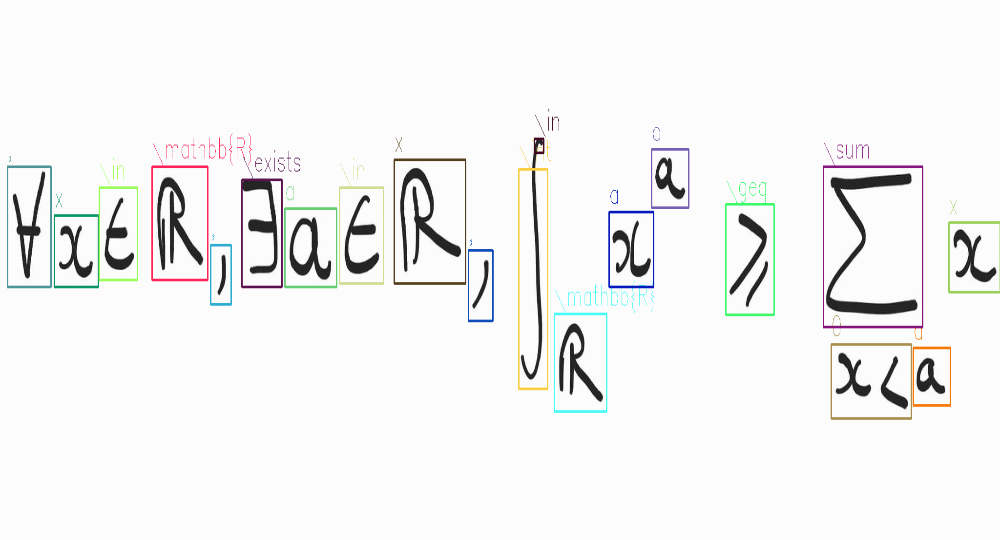

In [ ]:
image = cv2.imread("formule.jpg")
output=image.copy()
print(len(boxes), len(preds))
for i in range(len(boxes)):
  (x,y,w,h) = boxes[i]
  color = [random.randint(0,255) for j in range(0,3)]
  cv2.rectangle(output, (x,y), (x+w, y+h), color, 2)
  cv2.putText(output, characters[int(preds[i][0])], (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1.1, color, 1)
  #cv2_imshow(output)
  #print(i)
output_big = cv2.resize(output, (1000, 540))
cv2_imshow(output_big)

#print(pdf)